# BMEN 509 - Lab 2 Tutorial
This document is a job aid for the handwritten notes matching the same description. The notes will refer specifically to headings in this notebook to match theory with implementation.

Created by Bryce Besler (babesler@ucalgary.ca), last edited January 28th, 2019
Edited on 04 Feb, 2021 Shirshak Shrestha (shirshak.shrestha@ucalgary.ca), 

## Notebook Setup

In [2]:
# Library Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from scipy import signal, ndimage
from mpl_toolkits.mplot3d import Axes3D

# Interactivity
from ipywidgets import interactive

# Setup Jupyter notebook specifics
%matplotlib inline

# Numpy printing help
np.set_printoptions(precision=2)

In [3]:
# Constants
data_directory = os.path.join('.', 'Data')
file_names = [
    'BreastUltrasound5.tif', 'T1Weighted8.jpg',
    'Thorax_PD.png', 'calcs_grids.tiff',
    'knee_ct2.tif', 'knee_xray2.tif',
    'mri_T2.tif', 'mri_brain.tif',
    'mri_pd.tif'
]

In [4]:
# Verify we can find our files
for file_name in file_names:
    name = os.path.join(data_directory, file_name)
    if not os.path.isfile(name):
        os.sys.exit('Cannot find file {}. Please make sure you have downloaded the data'.format(name))
print('Found all image files!')

Found all image files!


### Fourier Transform (Representation of signal as a sum of their frequencies)

$$ y(t) = \sum\limits_{n=0}^\infty A_n Cos(w_nt+\phi_n)$$
if  
$$cos(\alpha) = \frac{1}{2}[e^{j\alpha} + e^{-j\alpha}]$$
then  
$$ y(t) = \sum\limits_{n=-\infty}^{\infty} M_n e^{j\phi_n} e^{jw_nt}$$
where  
$$ M_n = \frac{A_n}{2} $$

### Example 1 - Cosine Magnitude and Phase
Below, cosine functions are added and their magnitude and phase diagrams plotted using the Fourier transform. This example demonstrates the fundamentals of the Fourier transform.

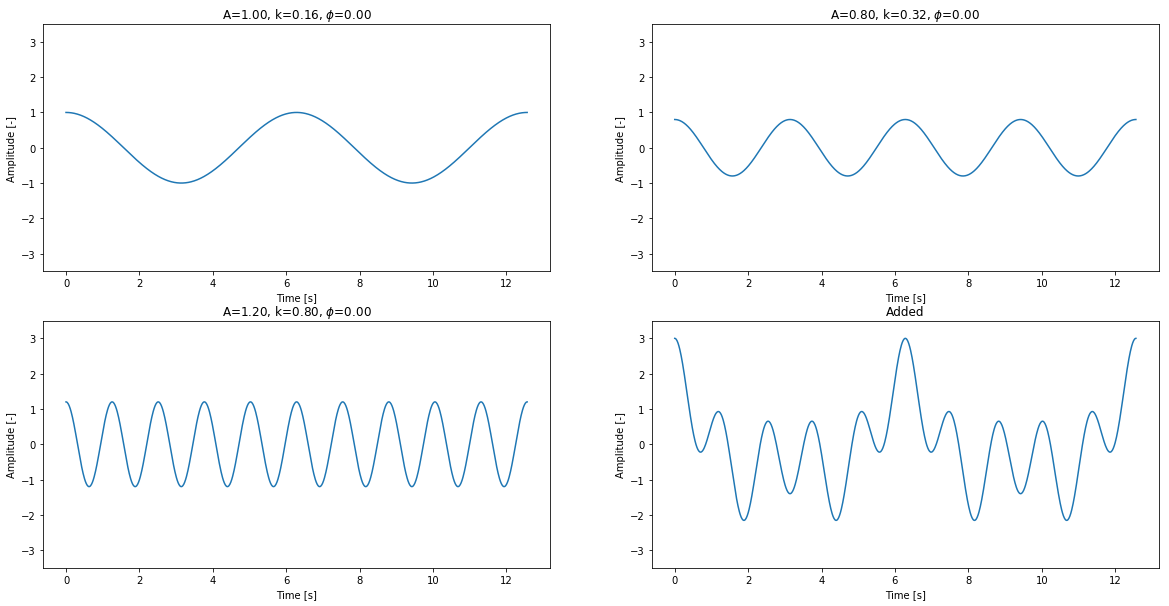

In [12]:
# Let's define the parameters of our three cosines
omega = np.array([1, 2, 5])           # Units of rad/s
amplitude = np.array([1, 0.8, 1.2])   # Arbitrary units
phase = np.array([0, 0, 0])           # Units of rads
# f = 2*np.pi*omega                     # Convert angular frequency to linear frequency
f = omega/(2*np.pi)                   # Convert angular frequency to linear frequency

# Create a time vector to visualize two periods of the signal with the largest period
T = 1./np.min(f)
nSamples = 1000
t = np.linspace(0, 1, nSamples)*2*T

# Create our cosine functions and add them together
cosine1 = amplitude[0] * np.cos(2*np.pi*f[0]*t + phase[0])
cosine2 = amplitude[1] * np.cos(2*np.pi*f[1]*t + phase[1])
cosine3 = amplitude[2] * np.cos(2*np.pi*f[2]*t + phase[2])
addedSignal = cosine1 + cosine2 + cosine3

# Plot our signal
plt.subplots(2, 2, figsize=(20,10))
plt.subplot(2, 2, 1); plt.plot(t, cosine1); plt.title('A={:0.2f}, k={:0.2f}, $\phi$={:0.2f}'.format(amplitude[0], f[0], phase[0])); plt.ylim([-3.5, 3.5]); plt.xlabel('Time [s]'); plt.ylabel('Amplitude [-]')
plt.subplot(2, 2, 2); plt.plot(t, cosine2); plt.title('A={:0.2f}, k={:0.2f}, $\phi$={:0.2f}'.format(amplitude[1], f[1], phase[1])); plt.ylim([-3.5, 3.5]); plt.xlabel('Time [s]'); plt.ylabel('Amplitude [-]')
plt.subplot(2, 2, 3); plt.plot(t, cosine3); plt.title('A={:0.2f}, k={:0.2f}, $\phi$={:0.2f}'.format(amplitude[2], f[2], phase[2])); plt.ylim([-3.5, 3.5]); plt.xlabel('Time [s]'); plt.ylabel('Amplitude [-]')
plt.subplot(2, 2, 4); plt.plot(t, addedSignal); plt.title('Added'); plt.ylim([-3.5, 3.5]); plt.xlabel('Time [s]'); plt.ylabel('Amplitude [-]')
plt.show()

Fourier Transform decomposes the signal into multiple cosine signals with an amplitude, frequency and phase.

/opt/conda/lib/python3.6/site-packages/matplotlib/transforms.py:954: ComplexWarning: Casting complex values to real discards the imaginary part
  self._points[:, 1] = interval


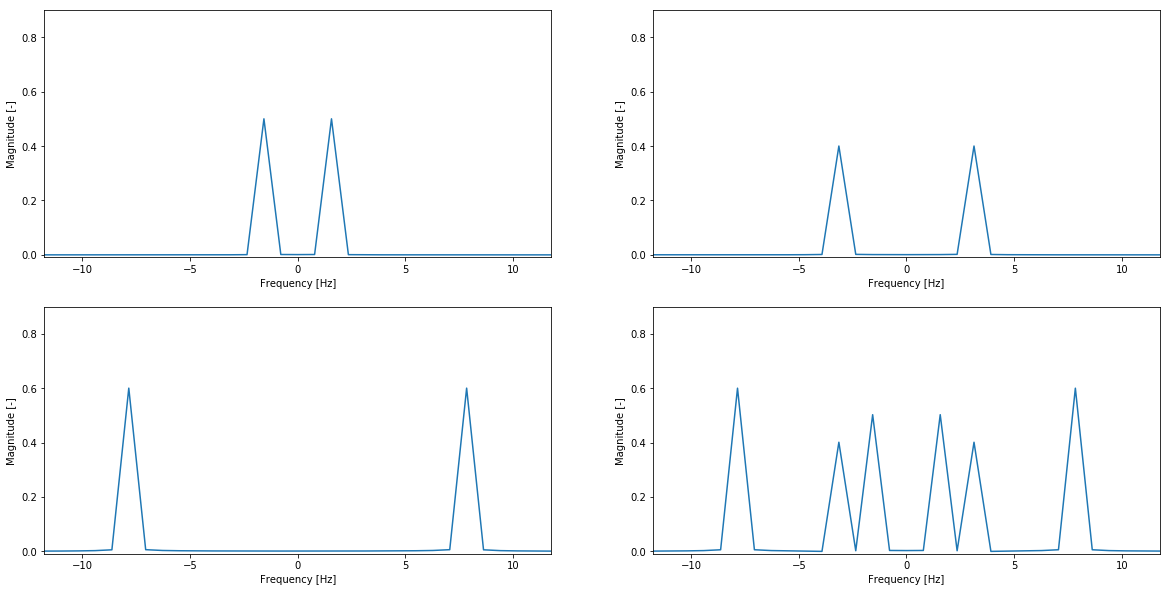

In [6]:
# Now, we want to compute the DFT. First we calculate our frequency vector
ts = t[1] - t[0]    # The sampling time
fs = 1./(ts);       # The sampling frequency
freq = np.fft.fftshift(np.fft.fftfreq(t.shape[-1], ts))

# Now, we compute the Discrete Fourier Transform using the Fast Fourier Transform algorithm.
# Note the division by number of samples.
cosine1DFT = np.fft.fftshift(np.fft.fft(cosine1))/nSamples
cosine2DFT = np.fft.fftshift(np.fft.fft(cosine2))/nSamples
cosine3DFT = np.fft.fftshift(np.fft.fft(cosine3))/nSamples
addedSignalDFT = np.fft.fftshift(np.fft.fft(addedSignal))/nSamples

# Determine the limits of plotting
ylim = [1.5*np.min(addedSignalDFT), 1.5*np.max(addedSignalDFT)]
xlim = [-1.5*np.max(f), 1.5*np.max(f)]

# Plot our magnitude response
plt.subplots(2, 2, figsize=(20,10))
plt.subplot(2, 2, 1); plt.plot(freq, np.abs(cosine1DFT)); plt.ylim(ylim); plt.xlim(xlim); plt.xlabel('Frequency [Hz]'); plt.ylabel('Magnitude [-]')
plt.subplot(2, 2, 2); plt.plot(freq, np.abs(cosine2DFT)); plt.ylim(ylim); plt.xlim(xlim); plt.xlabel('Frequency [Hz]'); plt.ylabel('Magnitude [-]')
plt.subplot(2, 2, 3); plt.plot(freq, np.abs(cosine3DFT)); plt.ylim(ylim); plt.xlim(xlim); plt.xlabel('Frequency [Hz]'); plt.ylabel('Magnitude [-]')
plt.subplot(2, 2, 4); plt.plot(freq, np.abs(addedSignalDFT)); plt.ylim(ylim); plt.xlim(xlim); plt.xlabel('Frequency [Hz]'); plt.ylabel('Magnitude [-]')
plt.show()

Concept check: Why do we see six 'spikes' - or delta functions - in the added signal fourier transform? What do the amplitudes of those 'spikes' correspond to? (Try multiplying by 2)

### 2D Fourier Transform
$$ y(t) == \sum\limits_{m=0}^\infty \sum\limits_{n=0}^\infty A_{mn} Cos(w_{mx}+w_{ny}+\phi_{mn})$$

While 1D FT is a line, 2D FT is a plane
Code: `numpy.fft.fft2`


### Example 2 - The Sawtooth Function and it's Frequency Components
Below, we take the fourier transform of the sawtooth function. We start with a single cosine and iteratively add components back, seeing how these components add together.

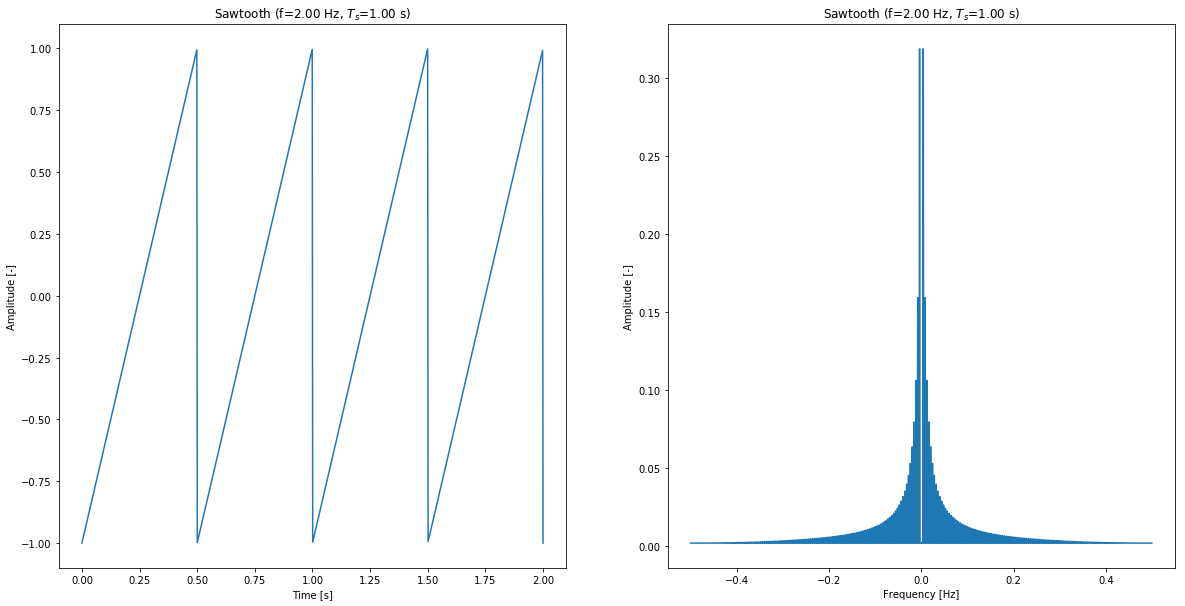

In [9]:
# Create a time vector to visualize two periods of the signal with the largest period
T = 1
nSamples = 1000
f = 2

# Create the signal
t = np.linspace(0, 1, nSamples)*2*T
y = signal.sawtooth(2*np.pi*f*t)

# Let's do a DFT as well
freq = np.fft.fftshift(np.fft.fftfreq(t.shape[-1], T))
dft = np.fft.fftshift(np.fft.fft(y))/nSamples

plt.subplots(1, 2, figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(t, y)
plt.title('Sawtooth (f={:0.2f} Hz, $T_s$={:0.2f} s)'.format(f, T))
plt.xlabel('Time [s]')
plt.ylabel('Amplitude [-]')
plt.subplot(1, 2, 2)
plt.plot(freq, np.abs(dft))
plt.title('Sawtooth (f={:0.2f} Hz, $T_s$={:0.2f} s)'.format(f, T))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [-]')
plt.show()

![Sawtooth Wave](https://web.njit.edu/~matveev/Courses/M331_F18/html/FourierSawToothSine_01.png)  
NJIT-matveev: https://web.njit.edu/~matveev/Courses/M331_F18/html/FourierSawToothSine_01.png

In [13]:
# Now, let's see what happens when we use only the first X percent of frequency samples!
def plotter(percentage=1):
    plt.figure(1, figsize=(25, 10))
    
    # Only take the first X percentage of components. Set the rest to zero.
    cutoff_freq = np.max(freq)*percentage
    ind = np.logical_or(freq>cutoff_freq, freq<-cutoff_freq)
    this_dft = dft.copy()
    this_dft[ ind ] = 0
    
    result = np.fft.ifft(np.fft.fftshift(this_dft*nSamples))
    
    # First, we plot the frequency components
    plt.subplot(1, 2, 1)
    plt.plot(freq, np.abs(this_dft))
    plt.title('Percentage = {}'.format(percentage))
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude [-]')

    # Second, plot the reconstructed signal
    plt.subplot(1, 2, 2)
    plt.plot(t, result)
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude [-]')
    
    plt.show()
    
interactive_plot = interactive(plotter, percentage=(0.0, 1.0, 0.01))
output = interactive_plot.children[-1]
output.layout.height = '500px'
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='percentage', max=1.0, step=0.01), Output(layout=Layo…

Concept Check: Can you see the 'sum of cosines' in the truncated sawtooth function? What is Gibb's ringing?

### Example 3 - Cosine Images
We are going to repeat Example 1, except with two dimension cosines!

<Figure size 432x288 with 0 Axes>

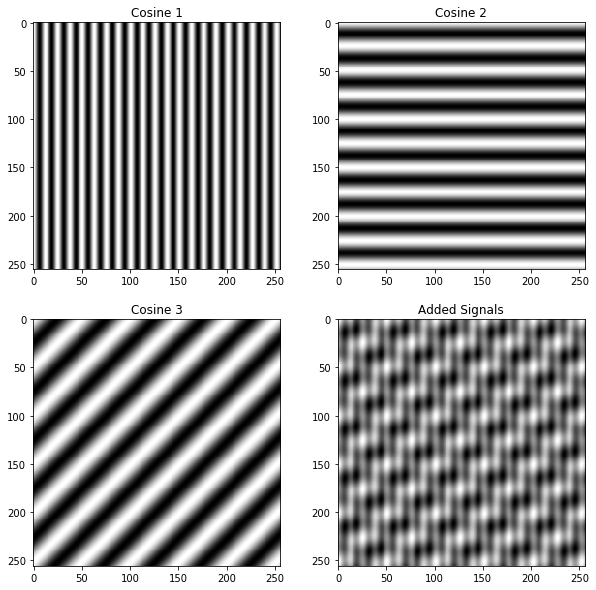

<Figure size 432x288 with 0 Axes>

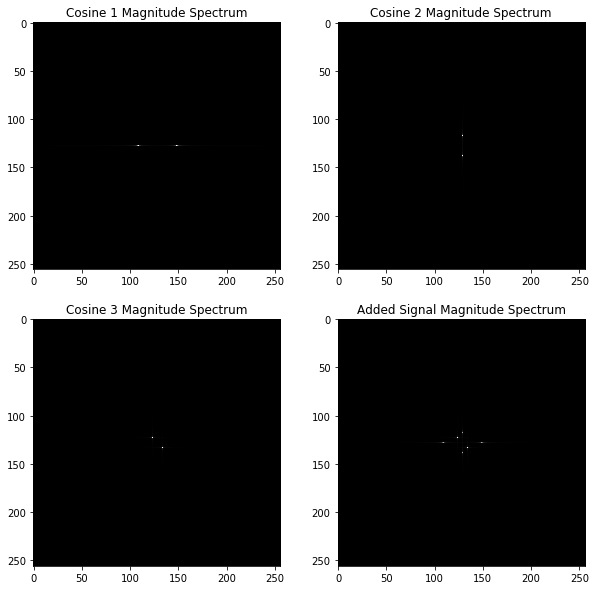

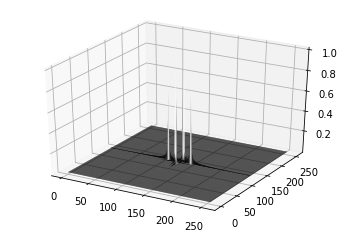

In [8]:
# Here we are going to repeat the last exercise, but with images (2 dimensional signals). 
omegaX = np.array([1/2, 0, 1/8])         # Units of rad/s
omegaY = np.array([0, 1/4, 1/8])         # Units of rad/s
amplitude = np.array([1, 0.8, 1.2])      # Arbitrary units
phase = np.array([0, 0, 0])              # Units of rads
width = 256;                             # How large our image is

# Create a base for the images
x = np.linspace(0, width-1, width);
y = np.linspace(0, width-1, width);
[XX, YY] = np.meshgrid(x,y);

# Create images
cosine1 = amplitude[0] * np.cos(omegaX[0]*XX + omegaY[0]*YY + phase[0])
cosine2 = amplitude[1] * np.cos(omegaX[1]*XX + omegaY[1]*YY + phase[1])
cosine3 = amplitude[2] * np.cos(omegaX[2]*XX + omegaY[2]*YY + phase[2])
addedSignal =  cosine1 + cosine2 + cosine3;

# Plot images
plt.figure(1)
plt.subplots(2, 2, figsize=(10, 10))
plt.subplot(2,2,1); plt.imshow(cosine1, cmap='gray'); plt.title('Cosine 1');
plt.subplot(2,2,2); plt.imshow(cosine2, cmap='gray'); plt.title('Cosine 2');
plt.subplot(2,2,3); plt.imshow(cosine3, cmap='gray'); plt.title('Cosine 3');
plt.subplot(2,2,4); plt.imshow(addedSignal, cmap='gray'); plt.title('Added Signals');
plt.show()

# Take the DFT
cosine1DFT = np.fft.fftshift(np.fft.fft2(cosine1))
cosine2DFT = np.fft.fftshift(np.fft.fft2(cosine2))
cosine3DFT = np.fft.fftshift(np.fft.fft2(cosine3))
addedSignalDFT = np.fft.fftshift(np.fft.fft2(addedSignal))

# Get Magnitude
cosine1Magnitude = (abs(cosine1DFT)+1) / (max(abs(cosine1DFT.ravel())+1))
cosine2Magnitude = (abs(cosine2DFT)+1) / (max(abs(cosine2DFT.ravel())+1))
cosine3Magnitude = (abs(cosine3DFT)+1) / (max(abs(cosine3DFT.ravel())+1))
addedSignalMagnitude = (abs(addedSignalDFT)+1) / (max(abs(addedSignalDFT.ravel())+1))

# Plot the DFTs
plt.figure(2)
plt.subplots(2, 2, figsize=(10, 10))
plt.subplot(2,2,1); plt.imshow(cosine1Magnitude, cmap='gray'); plt.title('Cosine 1 Magnitude Spectrum');
plt.subplot(2,2,2); plt.imshow(cosine2Magnitude, cmap='gray'); plt.title('Cosine 2 Magnitude Spectrum');
plt.subplot(2,2,3); plt.imshow(cosine3Magnitude, cmap='gray'); plt.title('Cosine 3 Magnitude Spectrum');
plt.subplot(2,2,4); plt.imshow(addedSignalMagnitude, cmap='gray'); plt.title('Added Signal Magnitude Spectrum');
plt.show()

# Create the 3D plot
fig = plt.figure(3)
ax = fig.gca(projection='3d')
ax.plot_surface(XX, YY, addedSignalMagnitude ,rstride=1, cstride=1, cmap=plt.cm.gray, linewidth=0)
plt.show()

The cosine functions appear as points in the magnitude spectrum. Why points? In the added signal, why are some points brighter than other? (Think amplitude).

### Example 4 - Fourier Transform of Real Images
Let's just see some real images!

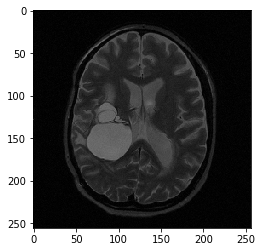

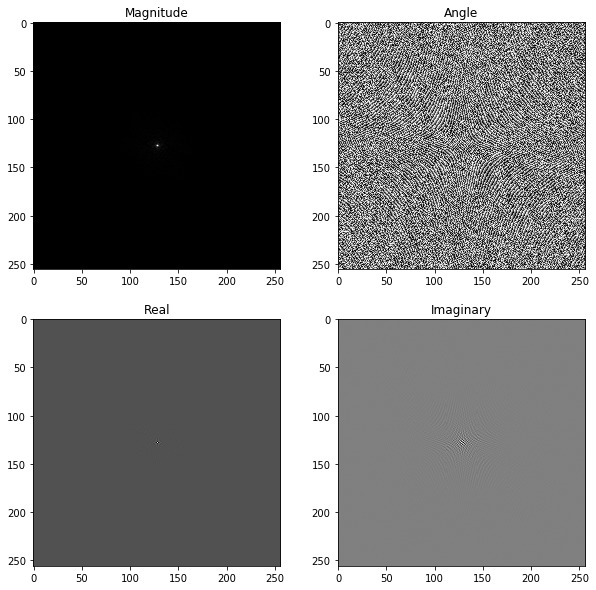

In [9]:
# Read the image
file_name = 'mri_T2.tif'
image = io.imread(os.path.join(data_directory, file_name))
plt.imshow(image, cmap='gray')
plt.show()

# Let's compute the DFT
dft = np.fft.fftshift(np.fft.fft2(image))

# Let's just visualize all the components
plt.subplots(2, 2, figsize=(10, 10))
plt.subplot(2, 2, 1); plt.imshow(np.abs(dft), cmap='gray'); plt.title('Magnitude')
plt.subplot(2, 2, 2); plt.imshow(np.angle(dft), cmap='gray'); plt.title('Angle')
plt.subplot(2, 2, 3); plt.imshow(np.real(dft), cmap='gray'); plt.title('Real')
plt.subplot(2, 2, 4); plt.imshow(np.imag(dft), cmap='gray'); plt.title('Imaginary')
plt.show()

This looks aweful! We need to apply some intensity transforms to make these look better.

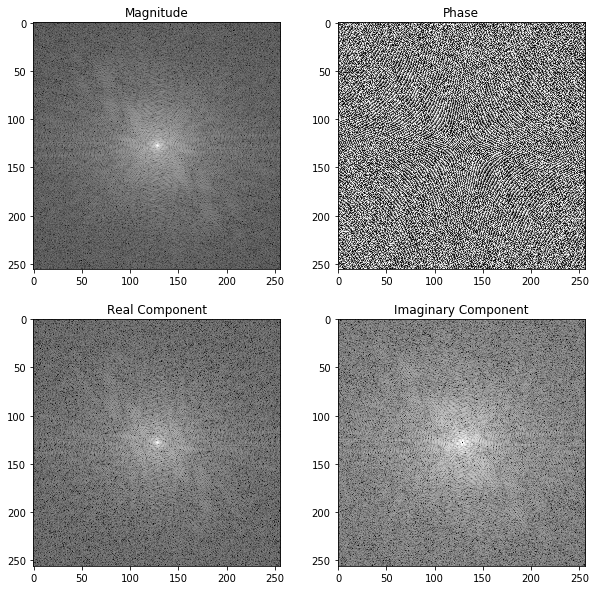

In [10]:
# For the magnitude, we do a log-transform. We add one to prevent log(0) -> infinity.
# We also divide by the maximum response in the image to normalize the image.
mag = np.log(np.abs(dft)+1);
mag = mag / np.log(np.max(np.abs(dft.ravel())+1))

# There is really nothing to do for the phase. Here, the phase has been
# rescaled to [0, 2*pi). It is absolutely valid to use angle(.) without rescaling.
phase = (np.angle(dft) + np.pi) / (2*np.pi);

# For the real component, we again scale by the log and the maximum
# response in the image. However, we take the absolute value. This changes
# the interpretation of the image because you make negative values positive.
real = np.log(np.abs(np.real(dft))+1) / np.log(np.max(np.abs(np.real(dft.ravel())) + 1))
imag = np.log(np.abs(np.imag(dft))+1) / np.log(np.max(np.abs(np.imag(dft.ravel())) + 1))

# For imshow, we quickly need to convert everything to float
mag = mag.astype(np.double)
phase = phase.astype(np.double)
real = real.astype(np.double)
imag = imag.astype(np.double)

# And plot!
plt.subplots(2, 2, figsize=(10, 10))
plt.subplot(2,2,1); plt.imshow(mag, cmap='gray');   plt.title('Magnitude');
plt.subplot(2,2,2); plt.imshow(phase, cmap='gray'); plt.title('Phase');
plt.subplot(2,2,3); plt.imshow(real, cmap='gray');  plt.title('Real Component');
plt.subplot(2,2,4); plt.imshow(imag, cmap='gray');  plt.title('Imaginary Component');
plt.show()

### Convolution in the frequency domain

Just multiply!

### Example 5 - Low Pass Filters Visualized
We are going to visualize the effects of a low pass filter on the frequency domain.

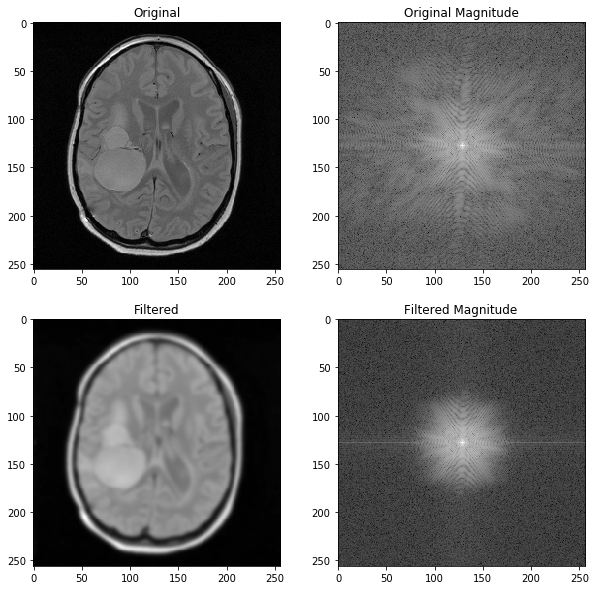

In [11]:
# Read an image
file_name = 'mri_pd.tif'
image = io.imread(os.path.join(data_directory, file_name))

# Apply that Gaussian filter
filtered = ndimage.filters.gaussian_filter(image, 2)

# Do the DFT
dft = np.fft.fftshift(np.fft.fft2(image))
image_mag = np.log(np.abs(dft)+1) / np.log(np.max(np.abs(dft.ravel()) + 1))
dft = np.fft.fftshift(np.fft.fft2(filtered))
filtered_mag = np.log(np.abs(dft)+1) / np.log(np.max(np.abs(dft.ravel()) + 1))

# Plot!
plt.subplots(2, 2, figsize=(10, 10))
plt.subplot(2, 2, 1); plt.imshow(image, cmap='gray'); plt.title('Original')
plt.subplot(2, 2, 2); plt.imshow(image_mag, cmap='gray'); plt.title('Original Magnitude')
plt.subplot(2, 2, 3); plt.imshow(filtered, cmap='gray'); plt.title('Filtered')
plt.subplot(2, 2, 4); plt.imshow(filtered_mag, cmap='gray'); plt.title('Filtered Magnitude')
plt.show()

### Example 6 - Let's determine the filter used!
We're going to reverse-engineer the blurring.

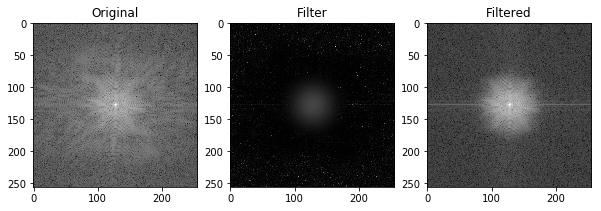

In [12]:
# Read an image
file_name = 'mri_pd.tif'
image = io.imread(os.path.join(data_directory, file_name))

# Apply that Gaussian filter
filtered = ndimage.filters.gaussian_filter(image, 2)

# Do the DFT
dft_image = np.fft.fftshift(np.fft.fft2(image))
dft_filtered = np.fft.fftshift(np.fft.fft2(filtered))

# Divide
dft_filter = dft_filtered / dft_image

# Let's prepare for visualization
image_mag = np.log(np.abs(dft_image)+1) / np.log(np.max(np.abs(dft_image.ravel()) + 1))
filtered_mag = np.log(np.abs(dft_filtered)+1) / np.log(np.max(np.abs(dft_filtered.ravel()) + 1))
filter_mag = np.log(np.abs(dft_filter)+1) / np.log(np.max(np.abs(dft_filter.ravel()) + 1))

# Visiualize
plt.subplots(1, 3, figsize=(10, 10))
plt.subplot(1, 3, 1); plt.imshow(image_mag, cmap='gray'); plt.title('Original')
plt.subplot(1, 3, 2); plt.imshow(filter_mag, cmap='gray'); plt.title('Filter')
plt.subplot(1, 3, 3); plt.imshow(filtered_mag, cmap='gray'); plt.title('Filtered')
plt.show()

See how $Filtered = Image * Filter$ using point-wise multiplication?

### Example 7 - Building a Filter in the Frequency Domain
Now, we're going to use this principles to apply a filter in the frequency domain.

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


<Figure size 432x288 with 0 Axes>

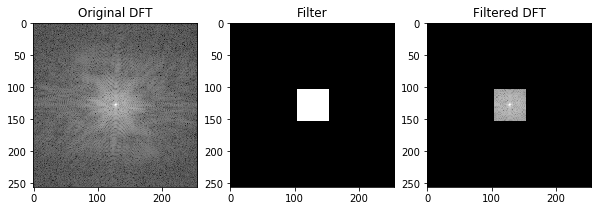

<Figure size 432x288 with 0 Axes>

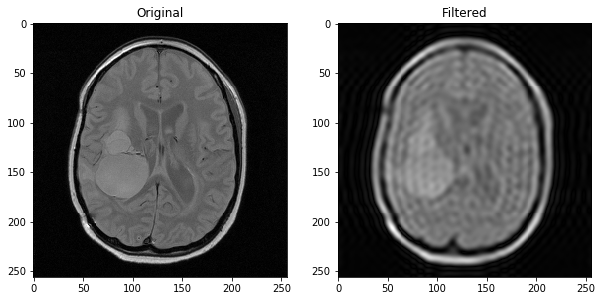

In [13]:
# Read an image
file_name = 'mri_pd.tif'
image = io.imread(os.path.join(data_directory, file_name))

# Take the DFT
dft_image = np.fft.fftshift(np.fft.fft2(image))
image_mag = np.log(np.abs(dft_image)+1) / np.log(np.max(np.abs(dft_image.ravel()) + 1))

# Build a low pass filter
H = np.zeros_like(dft_image)
mean = np.array(H.shape) / 2
for i in range(H.shape[0]):
    for j in range(H.shape[1]):
        if np.abs(mean[0] - i) < 25 and np.abs(mean[1] - j) < 25:
            H[i, j] = 1
H = H.astype(np.double)

# Apply the filter
new_image_dft = dft_image * H
new_image_mag = np.log(np.abs(new_image_dft)+1) / np.log(np.max(np.abs(new_image_dft.ravel()) + 1))

# Recovery the image
new_image = np.fft.ifft2(np.fft.fftshift(new_image_dft))
new_image = np.abs(new_image)

# Plot
plt.figure(1)
plt.subplots(1, 3, figsize=(10, 10))
plt.subplot(1, 3, 1); plt.imshow(image_mag, cmap='gray'); plt.title('Original DFT')
plt.subplot(1, 3, 2); plt.imshow(H, cmap='gray'); plt.title('Filter')
plt.subplot(1, 3, 3); plt.imshow(new_image_mag, cmap='gray'); plt.title('Filtered DFT')
plt.show()


plt.figure(2)
plt.subplots(1, 2, figsize=(10, 10))
plt.subplot(1, 2, 1); plt.imshow(image, cmap='gray'); plt.title('Original')
plt.subplot(1, 2, 2); plt.imshow(new_image, cmap='gray'); plt.title('Filtered')
plt.show()

We can see the image has a reduced resolution! Any idea why we see ringing?

![Filter](https://www.electronics-tutorials.ws/wp-content/uploads/2013/08/opamp78.gif?fit=333%2C224)  
Electronic Tutorials: https://www.electronics-tutorials.ws/wp-content/uploads/2013/08/opamp78.gif?fit=333%2C224